## Imports

In [1]:
import os
import typing
import random

import tqdm
import torch
import numpy
import pandas
import torchvision
import matplotlib.pyplot as plt
import pytorch_metric_learning.utils
import pytorch_metric_learning.miners
import pytorch_metric_learning.losses
import pytorch_metric_learning.samplers
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


## Load the small-faces dataset

In [2]:
! wget https://ml.gan4x4.ru/msu/dep-1.9/datasets/small_face_dataset.zip
! unzip small_face_dataset.zip -d dataset
! mv dataset/faces/* dataset/

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


'mv' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
train_images = torchvision.datasets.ImageFolder("dataset/training")
test_images = torchvision.datasets.ImageFolder("dataset/testing")

If dataset in cell above too easy for, you can try http://vis-www.cs.umass.edu/lfw/lfw.tgz



## Create dataset & dataloader classes

### Dataset class

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            name: str,
            dataset: torchvision.datasets.ImageFolder,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        self.name = name
        self.transform = None
        self.dataset = dataset
        self.classes = dataset.classes
        self.precalculated_transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(25)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

### Calculate mean and std

In [5]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = train_set.channel_stats()
print(mean, std)
del train_set

Preload train            : 100%|██████████| 370/370 [00:00<00:00, 2969.37it/s]

tensor([0.4372]) tensor([0.1931])


### Create datasets

In [6]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
test_set = MyDataset("test", test_images, transform = transform, preload = True, precalculate_transform = True)

Preload test             : 100%|██████████| 30/30 [00:00<00:00, 2606.02it/s]


In [7]:
print("Train classes count", len(train_set.classes))
print("Test classes count", len(test_set.classes))
print("Images size", train_set[0][0].shape)

Train classes count 37
Test classes count 3
Images size torch.Size([1, 96, 96])


### Display examples

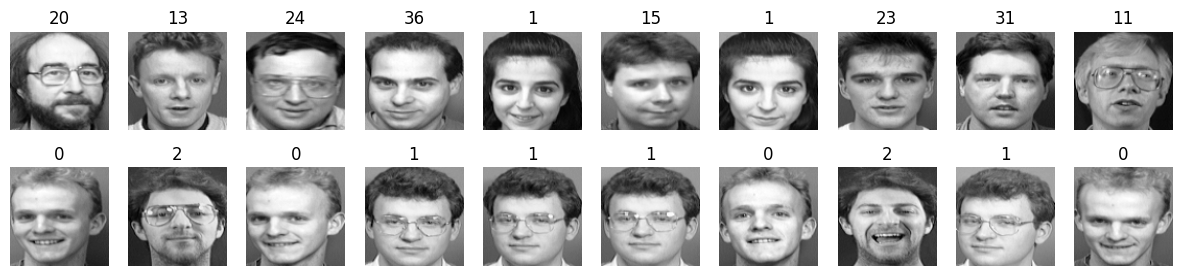

In [8]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = torch.zeros_like(mean), std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = torch.ones_like(std))
])

# Display some samples from each dataset
def display_examples(dataset: torch.utils.data.Dataset, row: int):
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8), cmap = 'gray')

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

### Create balanced dataloaders

In [9]:
def show_class_distribtion(labels):
    plt.figure(figsize = (10, 3))
    x, counts = labels.unique(return_counts = True)
    plt.bar(numpy.array(train_set.classes)[x], height = counts)

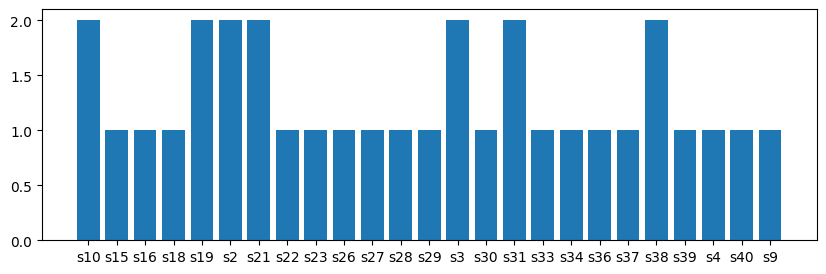

In [10]:
fix_random()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True)
show_class_distribtion(next(iter(train_loader))[1])

37

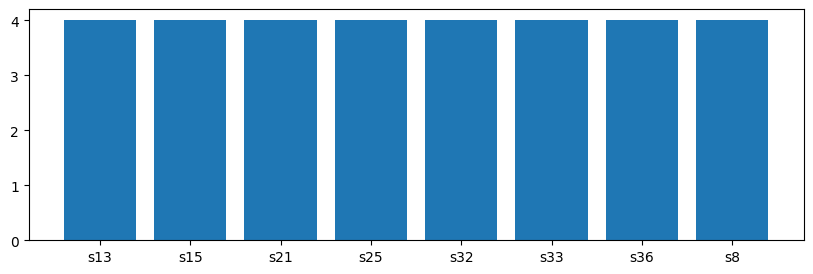

In [11]:
fix_random()
N_EPOCHS = 25
LENGTH_BEFORE_NEW_ITER = 1280
train_mpc_sampler = pytorch_metric_learning.samplers.MPerClassSampler(labels = train_set.targets, m = 4, length_before_new_iter = LENGTH_BEFORE_NEW_ITER)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, sampler = train_mpc_sampler)
show_class_distribtion(next(iter(train_loader))[1])
len(train_loader)

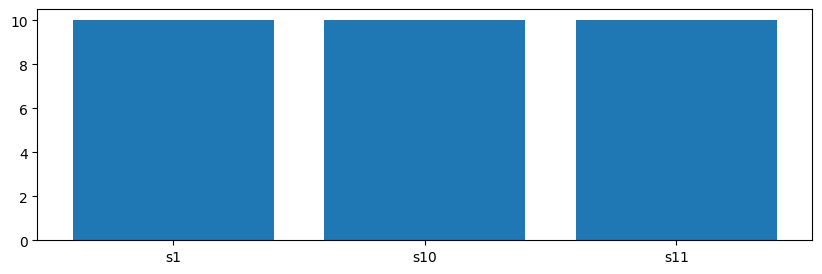

In [12]:
test_loader = torch.utils.data.DataLoader(train_set, batch_size = len(test_set))
show_class_distribtion(next(iter(test_loader))[1])

## Define the model for embedding extraction

In [13]:
EMBEDDING_SIZE = 128

In [14]:
def MyModel():
    model = torchvision.models.resnet50(num_classes = EMBEDDING_SIZE)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7, 7), padding = 3)
    # model.maxpool = torch.nn.Identity() # The images are already very small
    return model

model = MyModel()
model(next(iter(test_loader))[0]).shape

torch.Size([30, 128])

## Train the model

In [15]:
MARGIN = 1

In [16]:
fix_random()
all_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "all")
easy_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "easy")
semihard_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "semihard")
hard_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "hard")

images, labels = next(iter(train_loader))
embeddings = model(images)
print(embeddings.shape)

indices = all_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

indices = easy_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

indices = semihard_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

indices = hard_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

torch.Size([32, 128])
3 torch.Size([2688]) torch.Size([2688]) torch.Size([2688])
3 torch.Size([0]) torch.Size([0]) torch.Size([0])
3 torch.Size([1845]) torch.Size([1845]) torch.Size([1845])
3 torch.Size([843]) torch.Size([843]) torch.Size([843])


In [17]:
criterion = pytorch_metric_learning.losses.TripletMarginLoss(margin = MARGIN)
loss = criterion(embeddings, labels, indices)
print(loss)

tensor(1.0220, grad_fn=<MeanBackward0>)


In [18]:
del images
del labels
del embeddings
del indices
del loss

In [19]:
metrics = pytorch_metric_learning.utils.accuracy_calculator.AccuracyCalculator()
def validate(model: torch.nn.Module, device: torch.device) -> None:
    with torch.no_grad():
        images, targets = next(iter(test_loader))
        model = model.to(device)
        model.eval()
        embeddings = model(images.to(device))
        return metrics.get_accuracy(embeddings, targets.to(device))

validate(model, device)

d:\Programs\Programming\Python\lib\site-packages\faiss\contrib\torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


{'AMI': 0.4112754984866223,
 'NMI': 0.4546471258016355,
 'mean_average_precision': 0.7546090411642038,
 'mean_average_precision_at_r': 0.5902792475014697,
 'mean_reciprocal_rank': 0.9777778387069702,
 'precision_at_1': 0.9666666666666667,
 'r_precision': 0.6185185185185186}

In [20]:
def get_miner(epoch: int):
    if epoch < 5: return all_miner
    if epoch < 10: return easy_miner
    if epoch < 15: return semihard_miner
    return hard_miner

def train(model: torch.nn.Module, n_epochs: int, device: torch.device) -> None:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)    
    for epoch in range(n_epochs):
        sum_loss = 0
        for (images, targets) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            embeddings = model(images.to(device))
            indices = get_miner(epoch)(embeddings, targets)
            loss = criterion(embeddings, targets.to(device), indices)
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)
        metrics = validate(model, device)
        mean_avg_pr = metrics['mean_average_precision']
        AMI = metrics['AMI']
        NMI = metrics['NMI']
        print(f"Train loss: {train_loss:.5f}, Test MAP: {mean_avg_pr:.5f}, Test AMI: {AMI:.5f}, Test NMI: {NMI:.5f}")

fix_random()
train(model, N_EPOCHS, device)

Epoch 1: 100%|██████████| 37/37 [00:09<00:00,  3.70it/s]


Train loss: 0.82339, Test MAP: 0.97061, Test AMI: 0.89237, Test NMI: 0.89969


Epoch 2: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Train loss: 0.71177, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 3: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Train loss: 0.56631, Test MAP: 0.99886, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 4: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Train loss: 0.48701, Test MAP: 0.99907, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 5: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Train loss: 0.45142, Test MAP: 0.99720, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 6: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Train loss: 0.00000, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 7: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Train loss: 0.00000, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 8: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Train loss: 0.00000, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 9: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Train loss: 0.00000, Test MAP: 0.99907, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 10: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Train loss: 0.00000, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 11: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Train loss: 0.38349, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 12: 100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


Train loss: 0.36550, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 13: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Train loss: 0.31692, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 14: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Train loss: 0.33890, Test MAP: 0.99933, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 15: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Train loss: 0.30551, Test MAP: 1.00000, Test AMI: 0.62463, Test NMI: 0.65662


Epoch 16: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Train loss: 0.96821, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 17: 100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


Train loss: 0.99776, Test MAP: 0.98950, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 18: 100%|██████████| 37/37 [00:09<00:00,  4.02it/s]


Train loss: 0.92783, Test MAP: 0.99066, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 19: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Train loss: 0.72180, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 20: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Train loss: 0.75260, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 21: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Train loss: 0.35957, Test MAP: 0.99926, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 22: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Train loss: 0.44240, Test MAP: 0.99782, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 23: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Train loss: 0.49401, Test MAP: 0.99868, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 24: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Train loss: 0.38356, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 25: 100%|██████████| 37/37 [00:09<00:00,  4.01it/s]

Train loss: 0.41432, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


## Calculate metrics

In [ ]:
model.eval()

In [21]:
validate(model, device)

{'AMI': 1.0,
 'NMI': 1.0,
 'mean_average_precision': 1.0,
 'mean_average_precision_at_r': 1.0,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 1.0}

## Display the results

You can use faiss: https://github.com/facebookresearch/faiss

In [106]:
images, labels = next(iter(test_loader))
labels = numpy.array(test_set.classes)[labels]
with torch.no_grad():
    embeddings = model(images.to(device))

In [107]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s6,s6,s6,s6,s6,s6,s6,s6,s6,s6,s7,s7,s7,s7,s7,s7,s7,s7,s7,s7
s5,0.00,5.27,21.53,6.75,4.73,4.49,14.15,2.42,4.22,5.34,36.56,37.14,37.43,34.84,37.97,36.26,34.10,35.16,36.77,37.10,47.12,46.94,50.41,51.54,61.68,60.00,44.75,52.29,54.82,50.20
s5,5.27,0.00,25.70,9.82,8.24,6.99,18.62,5.94,3.76,1.78,31.82,32.55,32.98,30.12,33.14,31.45,29.56,30.48,31.98,32.16,45.83,45.93,49.78,50.85,61.37,59.48,43.20,51.42,54.62,49.33
s5,21.53,25.70,0.00,16.54,19.04,19.93,7.84,20.95,22.46,26.10,51.87,51.95,51.30,50.42,53.73,52.33,48.98,50.48,52.55,54.38,48.20,47.08,48.95,50.20,57.05,56.44,47.57,51.01,51.59,49.34
s5,6.75,9.82,16.54,0.00,5.74,4.92,10.20,6.11,7.22,10.49,37.85,38.01,38.27,36.45,39.55,37.93,35.09,36.39,38.28,39.48,44.62,44.27,47.83,48.97,58.20,56.72,42.91,49.22,51.87,47.33
s5,4.73,8.24,19.04,5.74,0.00,2.76,11.86,2.93,6.48,8.07,38.45,38.82,39.32,36.82,39.87,38.06,35.67,36.98,38.67,38.98,46.98,46.79,50.05,51.16,61.14,59.52,44.83,52.07,54.30,49.95
s5,4.49,6.99,19.93,4.92,2.76,0.00,12.96,2.87,5.47,7.21,36.40,36.64,37.27,34.85,37.89,36.06,33.52,34.88,36.64,37.14,45.29,45.16,48.70,49.79,59.78,58.10,43.20,50.43,52.99,48.35
s5,14.15,18.62,7.84,10.20,11.86,12.96,0.00,13.68,15.56,18.90,46.67,46.91,46.49,45.03,48.38,46.83,43.80,45.23,47.19,48.48,46.96,46.11,48.43,49.66,58.01,56.98,45.62,50.71,51.69,48.78
s5,2.42,5.94,20.95,6.11,2.93,2.87,13.68,0.00,4.83,5.80,36.93,37.38,37.92,35.31,38.34,36.55,34.31,35.49,37.13,37.40,47.24,47.11,50.59,51.70,61.80,60.11,44.98,52.44,54.97,50.34
s5,4.22,3.76,22.46,7.22,6.48,5.47,15.56,4.83,0.00,4.46,33.40,34.16,34.11,31.69,34.85,33.29,31.12,32.12,33.71,34.33,44.75,44.69,48.28,49.40,59.61,57.85,42.29,50.08,53.04,48.01
s5,5.34,1.78,26.10,10.49,8.07,7.21,18.90,5.80,4.46,0.00,32.48,33.28,33.79,30.76,33.72,31.99,30.25,31.16,32.59,32.49,46.88,47.00,50.75,51.82,62.46,60.55,44.18,52.54,55.63,50.41


![Alternative Text][1702032734246]

[1702032734246]: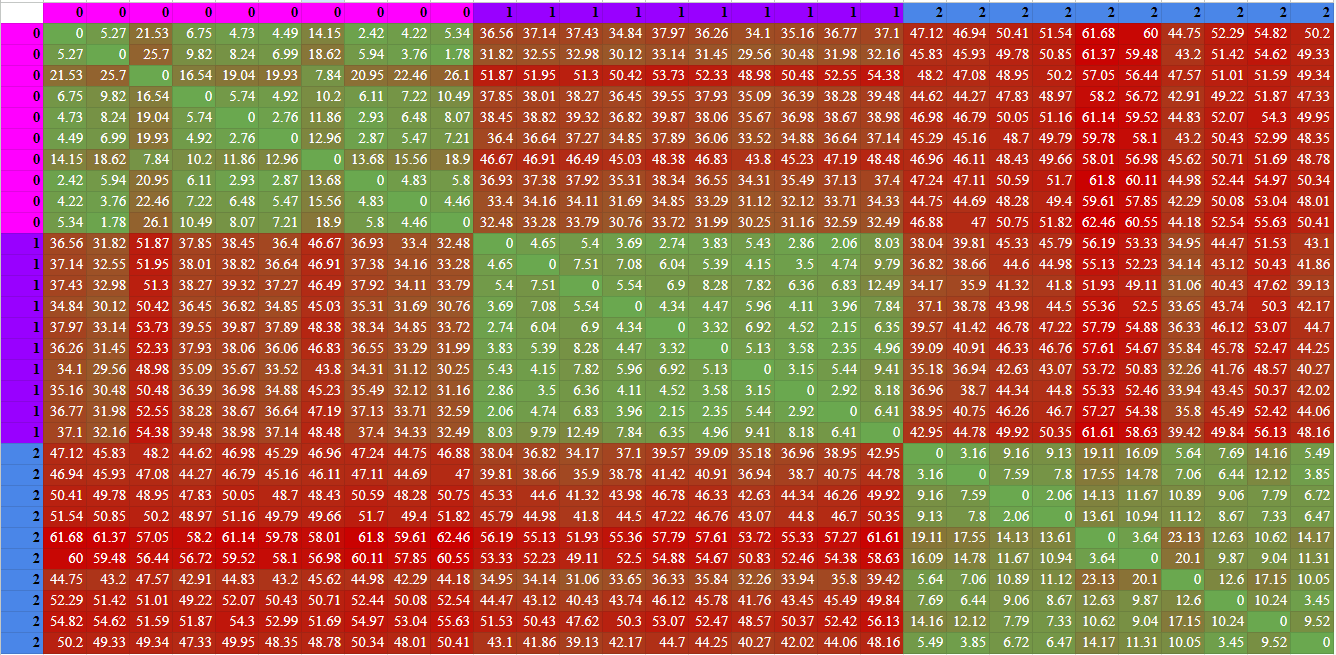

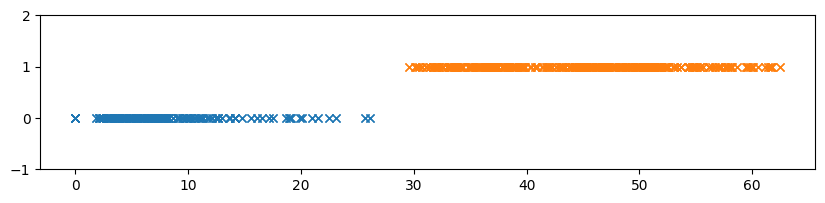

In [108]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        if label1 == label2: correct_dists.append(euc_dist)
        else: incorrect_dists.append(euc_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

In [109]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s6,s6,s6,s6,s6,s6,s6,s6,s6,s6,s7,s7,s7,s7,s7,s7,s7,s7,s7,s7
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
s5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


![Alternative Text][1702033949146]

[1702033949146]: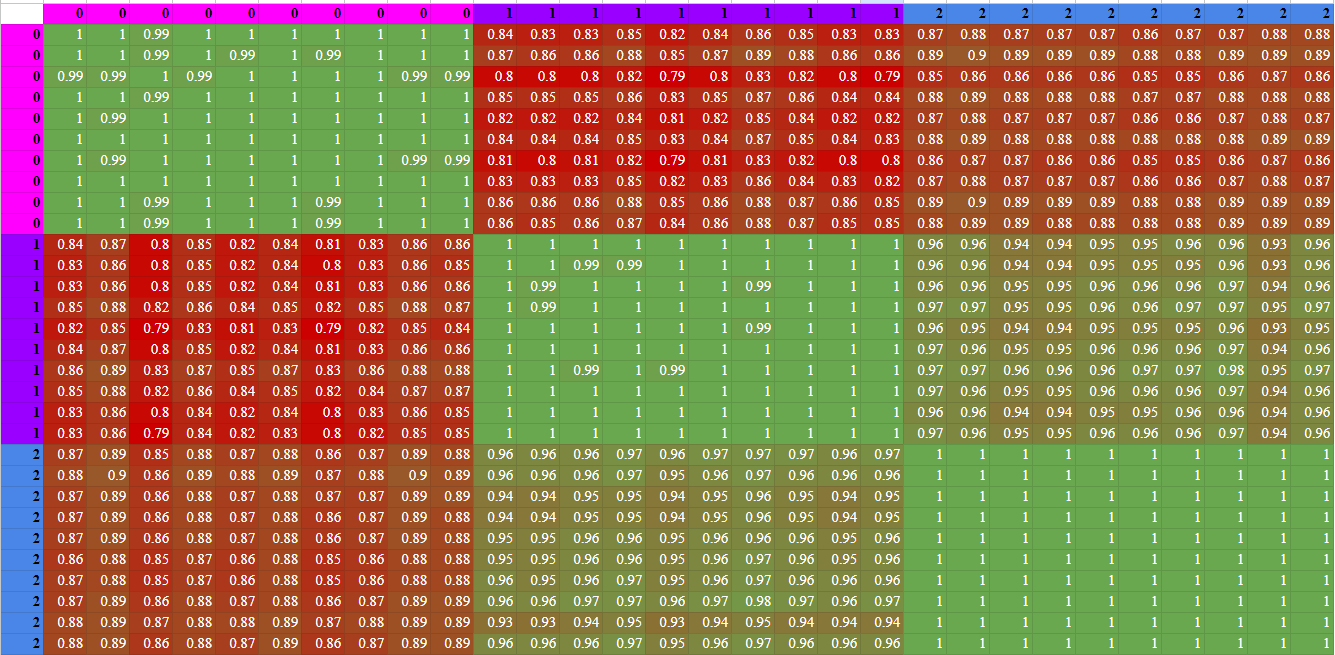

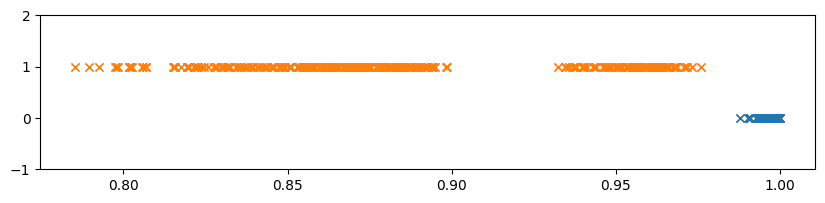

In [110]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        if label1 == label2: correct_dists.append(cos_dist)
        else: incorrect_dists.append(cos_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

In [111]:
embeddings = [ embeddings[0], embeddings[2], embeddings[6], embeddings[15], embeddings[25] ]
images = [ images[0], images[2], images[6], images[15], images[25] ]
labels = [ labels[0], labels[2], labels[6], labels[15], labels[25] ]

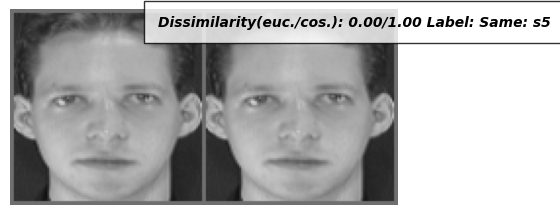

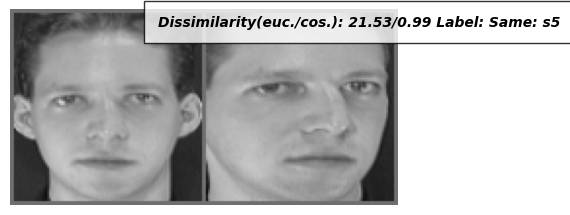

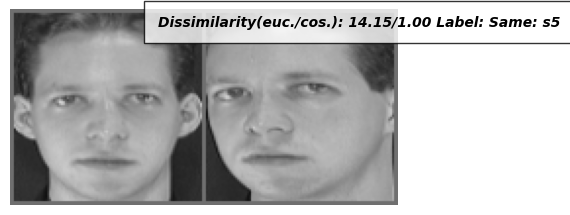

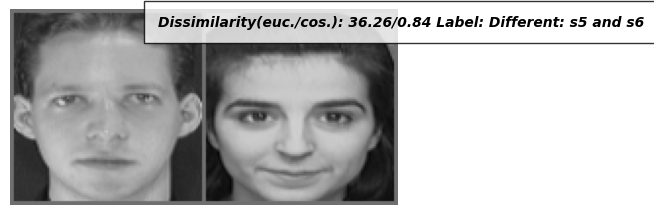

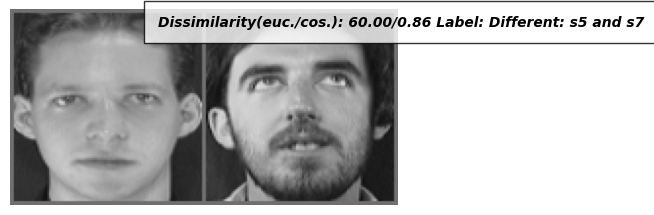

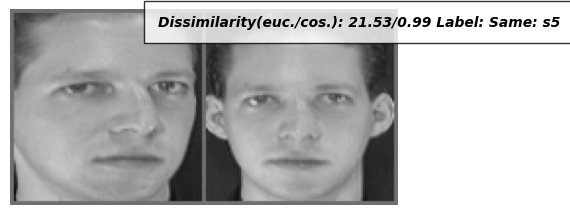

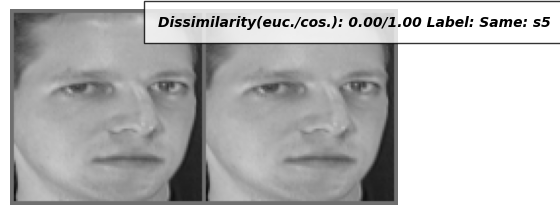

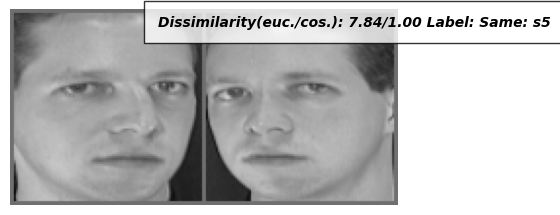

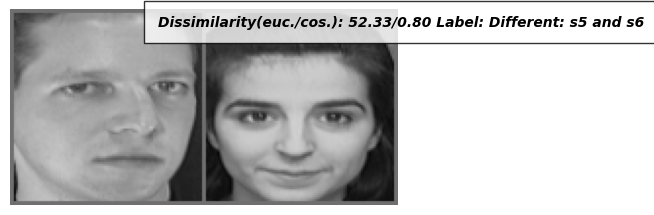

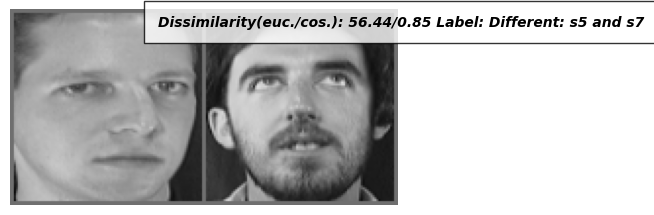

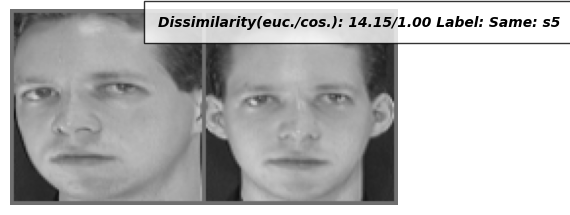

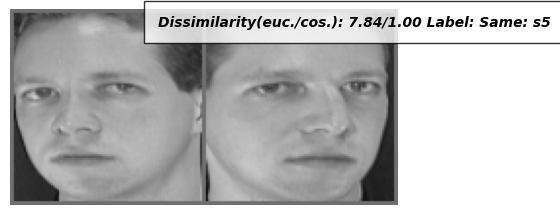

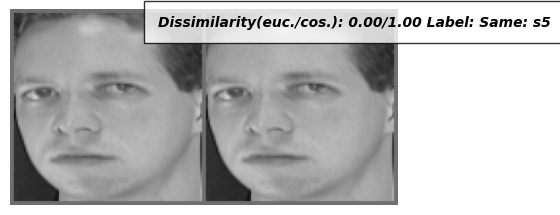

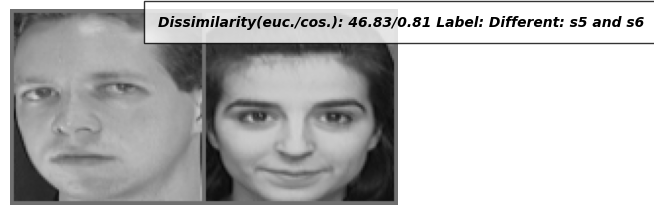

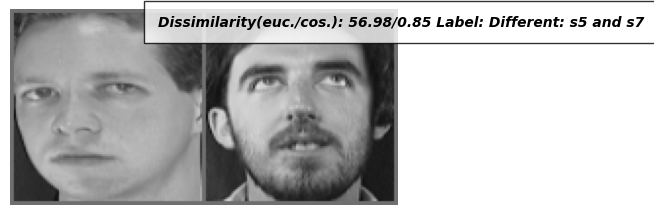

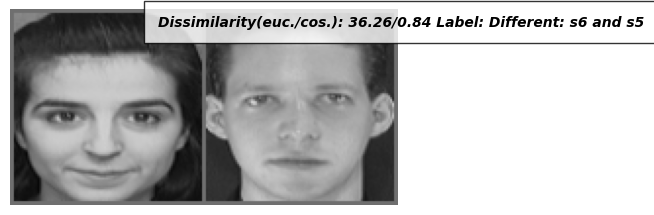

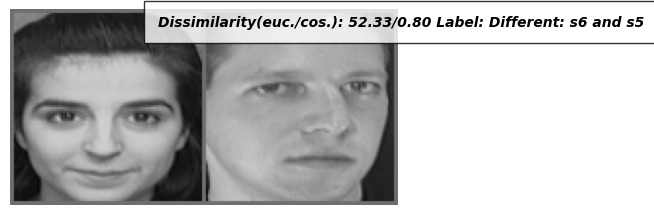

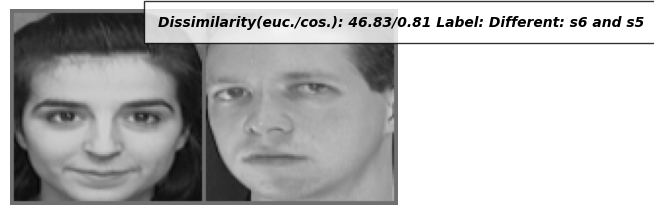

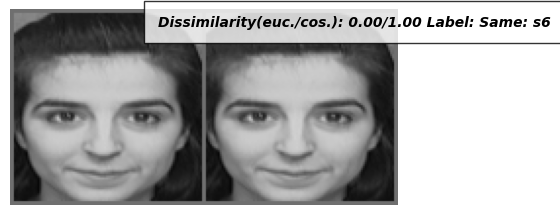

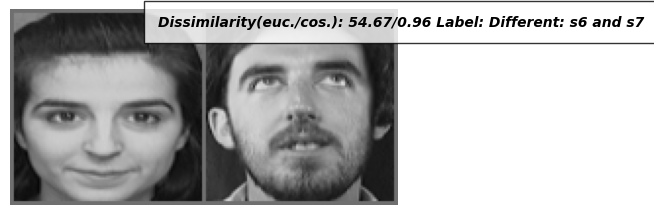

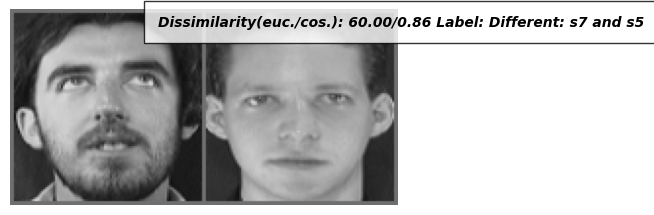

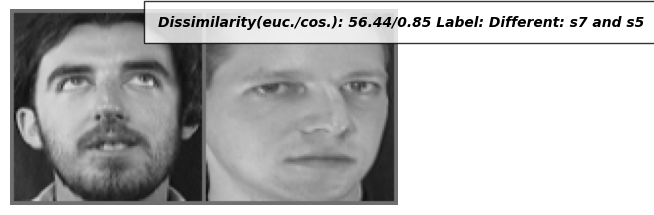

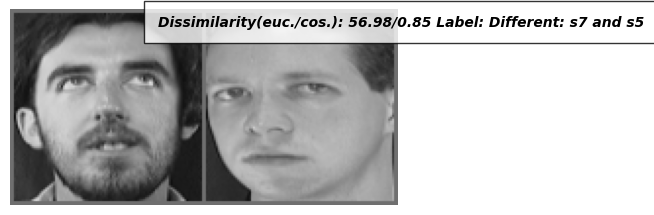

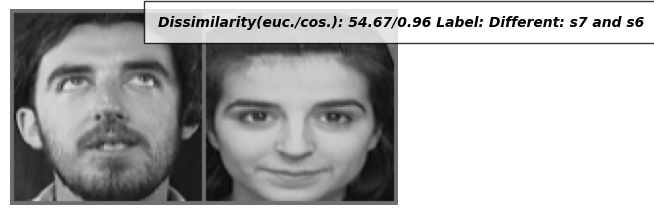

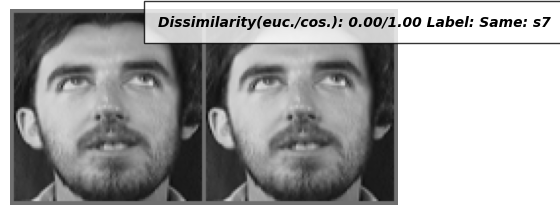

In [112]:
def imshow(img, text):
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.imshow((denormalize(img).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8), cmap = 'gray')
    plt.text(75, 8, text, style = 'italic', fontweight = 'bold', bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.show()

for (emb1, img1, label1) in zip(embeddings, images, labels):
    for (emb2, img2, label2) in zip(embeddings, images, labels):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        
        concatenated = torch.stack((img1, img2))
        label = "Same: {}".format(label1) if label1 == label2 else "Different: {} and {}".format(label1, label2)
        imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity(euc./cos.): {:.2f}/{:.2f} Label: {}'.format(euc_dist, cos_dist, label))

## Place for conclusion